# Name: **Gabriel Ohaike**
### Project#1 

## **Introduction**

- As a data scientist at Lyft Bay Wheels [Ford GoBike](https://www.lyft.com/bikes/bay-wheels), formerly known as Ford GoBike, the company running Bay Area Bikeshare. The company has task, my team, to come up with recommendations on how to increase ridership, and want to offer deals through the mobile app.

## **Research Questions** 

- The research explores two main pricing options currently offer to customers, the trips durations and stations among others that learn towards answering these interesting research questions.
   - What are the 5 most popular trips that you would call "commuter trips"?
   - What are your recommendations for offers (justify based on your findings)?

## **Data Sources**

- This research is primarily based on **Ford GoBike san fransisco** [public dataset](bigquery-public-data:san_francisco) which was created on Jan 31, 2017, 2:48:08 PM and was last modified on Mar 20, 2019, 4:23:03 PM as at the day of this research June, 2020.
- The dataset is subdivided into three
  - [bikeshare_stations](bigquery-public-data:san_francisco.bikeshare_stations)
  - [bikeshare_status](bigquery-public-data:san_francisco.bikeshare_status)
  - [bikeshare_trips](bigquery-public-data:san_francisco.bikeshare_trips)

## **Research Findings**

- This report presents an overview of current GoBike Bay wheel pricing and overall subscribers type model to analyze the current offer and finally offers recommendations to the company to modify current offerings

### **Research Analysis**

#### **We start by importing some tools needed for analysis**. 

In [47]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

##### *Before we answer the project questions, Lets take a look at some of the important factors that would help in making an informed decision*

- **What is the total trips recorded on san fransisco dataset and what are different types of subscribers?**

In [2]:
! bq query --use_legacy_sql=FALSE 'SELECT count(*) as total_trip FROM `bigquery-public-data.san_francisco.bikeshare_trips`'

Waiting on bqjob_r526c0a7fca4306ee_00000172817054cd_1 ... (0s) Current status: DONE   
+------------+
| total_trip |
+------------+
|     983648 |
+------------+


In [3]:
! bq query --use_legacy_sql=FALSE 'SELECT subscriber_type, COUNT(*) as count FROM `bigquery-public-data.san_francisco.bikeshare_trips` GROUP BY subscriber_type'

Waiting on bqjob_r65ef5cc32f776300_0000017281705b46_1 ... (0s) Current status: DONE   
+-----------------+--------+
| subscriber_type | count  |
+-----------------+--------+
| Customer        | 136809 |
| Subscriber      | 846839 |
+-----------------+--------+


##### Exploring the GoBike dataset revealed that there are a total of **983,648** trips

- **Are there more customers or subscribers making these trips?**

 *Further breakdown on the trips showed that out of 983,648 trips, 136,809 represents **13.9%** of customers while 846,839 represents **86.1%** subscribers*

## 1. **This brings us to our first project question**

- #### **What are the 5 most popular trips that you would call "commuter trips"?**

*Before we answer this question, let's explore all trips across stations and across the busiest hours and days of the week*

- **Top 5 Trips across all stations**

In [4]:
%%bigquery all_trip_freq
SELECT start_station_name, end_station_name, count(*) as all_trip_freq 
FROM `bigquery-public-data.san_francisco.bikeshare_trips` 
GROUP BY start_station_name, end_station_name ORDER BY all_trip_freq DESC LIMIT 20

In [5]:
all_trip_freq.head()

,start_station_name,end_station_name,all_trip_freq
0,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome,9150
1,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,8508
2,2nd at Townsend,Harry Bridges Plaza (Ferry Building),7620
3,Harry Bridges Plaza (Ferry Building),2nd at Townsend,6888
4,Embarcadero at Sansome,Steuart at Market,6874


- **What are the most busiest hours of the across all week?**

In [53]:
%%bigquery busiest_hour_allday
SELECT EXTRACT(HOUR FROM start_date) as Hour,EXTRACT(DAYOFWEEK FROM start_date) as weekday ,count(EXTRACT(HOUR FROM start_date)) as trip_count_all
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
GROUP BY Hour,weekday
ORDER BY trip_count_all DESC

**Top 5 trip weekdays and Hours**

In [56]:
busiest_hour_allday.sort_values(["trip_count_all"],ascending=[False]).head()

,Hour,weekday,trip_count_all
0,8,3,28138
1,8,4,27043
2,8,5,26014
3,17,3,25458
4,8,2,25443


**Least 5 trip weekdays and Hours**

In [58]:
busiest_hour_allday.sort_values(["trip_count_all"]).head()

,Hour,weekday,trip_count_all
167,4,1,56
166,2,3,65
165,4,7,69
164,3,7,74
163,2,2,74


- **Filtered busiest trip hours and weekdays?**

In [62]:
%%bigquery busiest_hour
SELECT EXTRACT(HOUR FROM start_date) as Hour, EXTRACT(DAYOFWEEK FROM start_date) as weekday,count(EXTRACT(HOUR FROM start_date)) as trip_count_weekday
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE EXTRACT(DAYOFWEEK from start_date) IN (2,3,4,5,6) 
GROUP BY Hour,weekday
ORDER BY trip_count_weekday DESC

In [64]:
busiest_hour.sort_values(["trip_count_weekday"],ascending=[False]).head()

,Hour,weekday,trip_count_weekday
0,8,3,28138
1,8,4,27043
2,8,5,26014
3,17,3,25458
4,8,2,25443


- **Plots comparing all trips and trips on weekdays**

<Figure size 864x648 with 0 Axes>

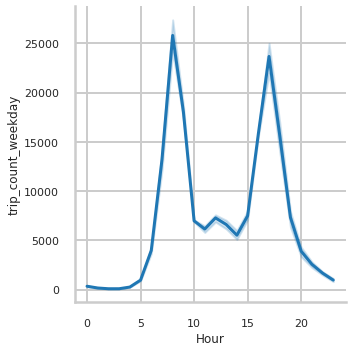

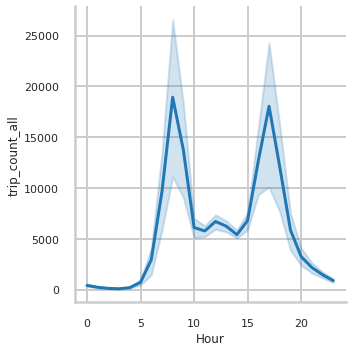

In [69]:
plt.figure(figsize=(12,9)) 
sns.relplot(x='Hour',y='trip_count_weekday',data=busiest_hour, kind="line")
sns.relplot(x='Hour',y='trip_count_all',data=busiest_hour_allday, kind="line")
pass

**The plots above compared the busiest trip time(hours) and counts for 7-day a week vs weekdays(Mon - Friday). Looking at both plots, they seemed to share common rush hours which is somewhere between 6 -10 in the morning and between 16 - 18 in the evening. Therefore, to get a true commuter trip, we need to consider only the trip for weekdays(Mon - Fri) and hours (6-10 & 16-8), this enables us to filter out commuters as chances are that there might be other users who are not commuters such as GoBike technicians and maintenance team etc.**

- Finally, this led us into 5 most popular trips we consider commuter trips below. Obviously, high surge in rush hour like 8,9,16,17,18 which correlate to weekdays are a shred evidence that those are commuter trips.

In [11]:
%%bigquery commuter_trip
SELECT count(trip_id) as trip_freq ,start_station_name, end_station_name,CONCAT(start_station_name, ' ','to', ' ',end_station_name) as trip  
FROM `bigquery-public-data.san_francisco.bikeshare_trips` 
WHERE EXTRACT(DAYOFWEEK from start_date) IN (2,3,4,5,6) AND EXTRACT(HOUR from start_date) IN (6,7,8,9,10,16,17,18,19)
GROUP BY start_station_name, end_station_name ORDER BY trip_freq DESC LIMIT 5

In [12]:
commuter_trip

,trip_freq,start_station_name,end_station_name,trip
0,6352,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,San Francisco Caltrain 2 (330 Townsend) to Tow...
1,5647,Harry Bridges Plaza (Ferry Building),2nd at Townsend,Harry Bridges Plaza (Ferry Building) to 2nd at...
2,5454,2nd at Townsend,Harry Bridges Plaza (Ferry Building),2nd at Townsend to Harry Bridges Plaza (Ferry ...
3,5218,Embarcadero at Sansome,Steuart at Market,Embarcadero at Sansome to Steuart at Market
4,5192,San Francisco Caltrain (Townsend at 4th),Harry Bridges Plaza (Ferry Building),San Francisco Caltrain (Townsend at 4th) to Ha...


### **5 most popular trips that you would call "commuter trips" are shown below**

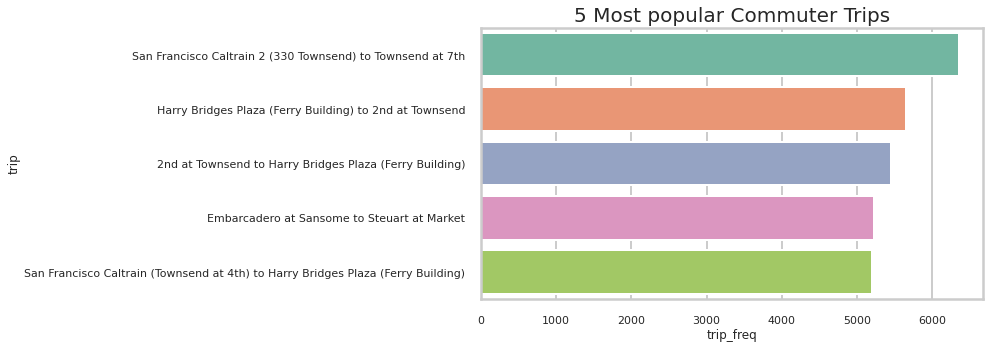

In [13]:
plt.figure(figsize=(9,5)) 
sns.set_context('poster',font_scale=0.5)
sns.set_style('whitegrid')
plt.title('5 Most popular Commuter Trips',fontsize =20)
sns.barplot(x="trip_freq", y="trip", data=commuter_trip, palette=sns.color_palette("Set2"))
pass

## 2.**What are your recommendations for offers (justify based on your findings)?**

### **Before we make recommendations, let's take a look at the current [GoBike Bay wheels Pricing]('https://www.lyft.com/bikes/bay-wheels/pricing')**

### **Summary of GoBike current offering:**

- Annual Membership: **149.00 per annum**. Free for the first **45 mins** ride and **3.00 per 15 mins after**
        
-  Monthly Membership:**15.00 per month**. Free for the first **45 mins ride and **3.00 per 15 mins after**
        
- Single Ride: **2.00 for the first 30 mins** and **3.00 per 15 mins** after.
        
- Access Pass: **10.00 per day for the first 30 mins** ride and **3.00 per 15 mins after**.(but you bike station by station to save cost)
    
- Ebiking: Members pay **0.15/minute**
  - Non-members pay 0.20/minute
  - Bike Share for All Members pay 0.05/minute with a cap of 1
  - Dock at any Bay Wheels station for free or use the cable to lock to a bike rack within the service area for 2. 
  - This charge will be waived if you park near a station that has no empty docks or park in part of the service area without stations. 
  - Always lock responsibly.This new pricing applies to ebike rides in San Francisco

### **Focus**
- We are going to base our research on two main subsciber type currently available on **san fransisco** dataset
  - Subscriber = annual or 30-day member
  - Customer = 24-hour or 3-day member

**From the GoBike current offering summary, we see two main subscriber types and their pricings. We are going to explore these offerings to ascertain whether the offering are suitable or not.** 

#### **First, lets filter all time between 5mins to 60 mins**

In [14]:
%%bigquery trip_hr_5_60

SELECT EXTRACT(HOUR FROM start_date) AS HR_of_day, duration_sec,(duration_sec/60) as duration_5mins_60mins,start_station_name,end_station_name,subscriber_type
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE ((duration_sec/60) >= 5 AND (duration_sec/60) <= 60)
ORDER BY (duration_sec/60) DESC

In [15]:
trip_hr_5_60.head()

,HR_of_day,duration_sec,duration_5mins_60mins,start_station_name,end_station_name,subscriber_type
0,12,3600,60.0,Embarcadero at Sansome,2nd at South Park,Customer
1,13,3600,60.0,Steuart at Market,Steuart at Market,Customer
2,15,3600,60.0,Mechanics Plaza (Market at Battery),Embarcadero at Vallejo,Customer
3,16,3600,60.0,2nd at Townsend,Grant Avenue at Columbus Avenue,Customer
4,9,3600,60.0,San Francisco Caltrain (Townsend at 4th),Mechanics Plaza (Market at Battery),Subscriber


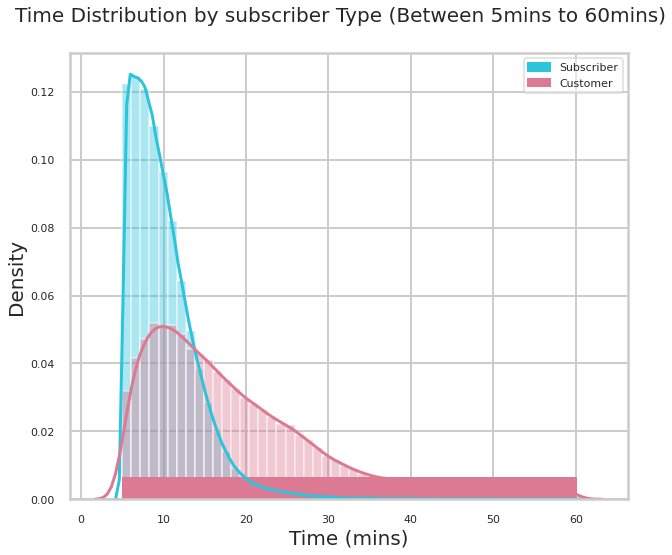

In [16]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle("Time Distribution by subscriber Type (Between 5mins to 60mins)",fontsize= 20)
fig.subplots_adjust(top=0.9)

sns.distplot(trip_hr_5_60.loc[trip_hr_5_60.subscriber_type=="Subscriber", "duration_5mins_60mins"], 
             norm_hist=True, color="#2bc4db", rug=True, bins=50)
sns.distplot(trip_hr_5_60.loc[trip_hr_5_60.subscriber_type=="Customer", "duration_5mins_60mins"], 
             norm_hist=True, color="#db7a92", rug=True, bins=50)

ax.set_ylabel("Density", fontsize=20)
ax.set_xlabel("Time (mins)", fontsize=20)

green_patch = matplotlib.patches.Patch(color="#2bc4db", label="Subscriber")
red_patch = matplotlib.patches.Patch(color="#db7a92", label="Customer")
ax.legend(handles=[green_patch, red_patch], facecolor="white", edgecolor="#cccccc", framealpha=0.5, fancybox=True)
pass

**The fig above is a plot of trip duration time in mins. The time was taking from duration_sec from GoBike trips datasets. Here, we decided to take a look at trip range between 5mins - 60mins and compared to subscriber types.**

## Findings
### **Here are some of the findings from the plots**.

 * You can see that most of the trips by subscribers averages around 10 -15 mins, on the high side, it barely get to 25mins of trip time. Why then do we offer 45mins?
 * On the other hand, the customer subscriber type averages 15 -20 mins and showed mores above 30 mins. This subscriber type showed more signs of longer trips is their offer is,nt restricted to 30 mins.Why then do we offer them less trip offering?

### In further analysis, let's take a closer look at the count above 30 mins and 45 mins respectively

In [17]:
! bq query --use_legacy_sql=FALSE 'SELECT subscriber_type , COUNT(*) as freq FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE (duration_sec/60) >= 30 GROUP BY subscriber_type'

Waiting on bqjob_r6c6ba07d32d3c11_0000017281713d67_1 ... (0s) Current status: DONE   
+-----------------+-------+
| subscriber_type | freq  |
+-----------------+-------+
| Customer        | 42032 |
| Subscriber      |  5336 |
+-----------------+-------+


### **As compared to the total trip count of subscriber type in the GoBike trips dataset**

In [18]:
! bq query --use_legacy_sql=FALSE 'SELECT subscriber_type , COUNT(*)as freq FROM `bigquery-public-data.san_francisco.bikeshare_trips` GROUP BY subscriber_type'

Waiting on bqjob_r2cc3545c4c55767a_0000017281714323_1 ... (0s) Current status: DONE   
+-----------------+--------+
| subscriber_type |  freq  |
+-----------------+--------+
| Customer        | 136809 |
| Subscriber      | 846839 |
+-----------------+--------+


- **From the two table above. Recall that there are 86.1% of subscribers as compared to 13.9% of customer in the GoBike Trips dataset. For trips of 30 mins or above, 89% are customer while 11% are subscriber**

### **Let us go further for trips of 45 mins and above** 

In [19]:
! bq query --use_legacy_sql=FALSE 'SELECT subscriber_type , COUNT(*) as freq FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE (duration_sec/60) >= 45 GROUP BY subscriber_type'

Waiting on bqjob_r55190a9e8843a581_0000017281714931_1 ... (0s) Current status: DONE   
+-----------------+-------+
| subscriber_type | freq  |
+-----------------+-------+
| Customer        | 31511 |
| Subscriber      |  2926 |
+-----------------+-------+


- **Again comparing trips of 45mins and above, 92% are customers while 8% are subscribers**

### Now let's get some insight about how to improve our present offering by looking at 

- The busiest stations

- Dock count


In [20]:
%%bigquery station_count
SELECT  start_station_id, COUNT(*) as freq FROM `bigquery-public-data.san_francisco.bikeshare_trips`GROUP BY start_station_id ORDER BY 2

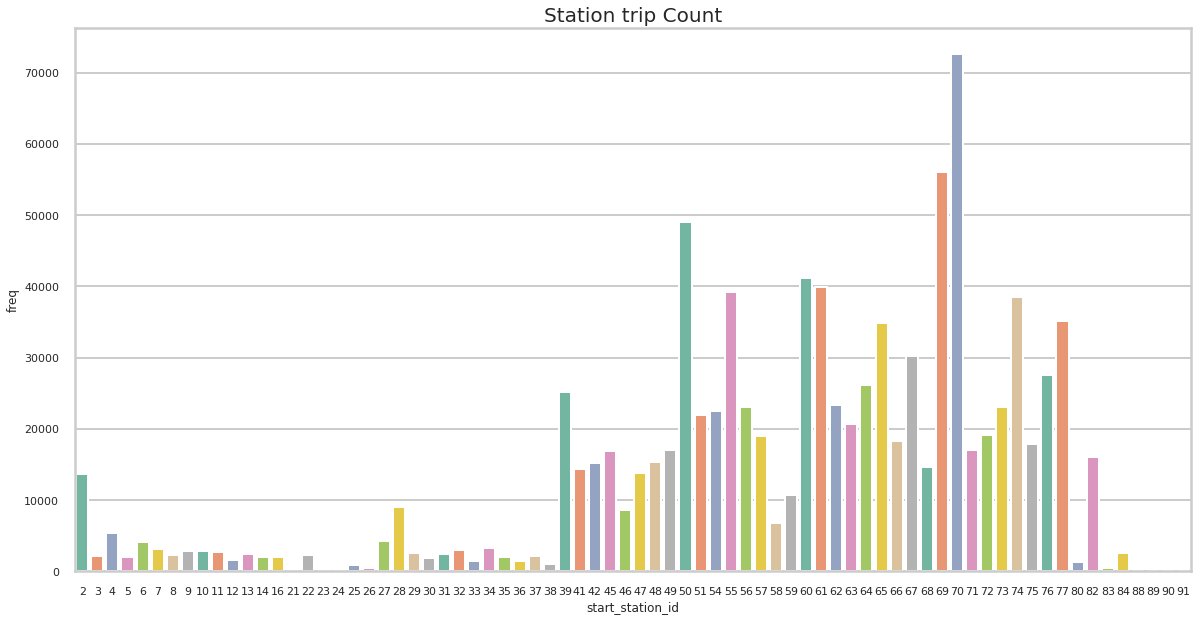

In [21]:
plt.figure(figsize=(20,10)) 
sns.set_context('poster',font_scale=0.5)
sns.set_style('whitegrid')
plt.title('Station trip Count',fontsize =20)
sns.barplot(x="start_station_id", y="freq", data=station_count, palette=sns.color_palette("Set2"))
pass

### Filtering out top 10 busiest stations

In [22]:
station_count.sort_values(['freq'], ascending=[False]).head(10)

,start_station_id,freq
73,70,72683
72,69,56100
71,50,49062
70,60,41137
69,61,39936
68,55,39200
67,74,38531
66,77,35142
65,65,34894
64,67,30209


### The figure above show the busiest station

In [24]:
%%bigquery dockcount
SELECT station_id, name, dockcount, FROM `bigquery-public-data.san_francisco.bikeshare_stations` 

In [25]:
dockcount.sort_values(['dockcount'], ascending=[False]).head(10)

,station_id,name,dockcount
73,91,Cyril Magnin St at Ellis St,35
72,90,5th St at Folsom St,31
71,77,Market at Sansome,27
70,67,Market at 10th,27
69,61,2nd at Townsend,27
68,2,San Jose Diridon Caltrain Station,27
67,22,Redwood City Caltrain Station,25
61,50,Harry Bridges Plaza (Ferry Building),23
58,34,Palo Alto Caltrain Station,23
59,29,San Antonio Caltrain Station,23


In [26]:
%%bigquery trip_status
SELECT DISTINCT station_id,bikes_available,docks_available
FROM `bigquery-public-data.san_francisco.bikeshare_status` LIMIT 1000000

In [27]:
#trip_status.tail()
trip_status.head()

,station_id,bikes_available,docks_available
0,91,4,31
1,91,6,29
2,91,12,23
3,91,3,32
4,91,2,33


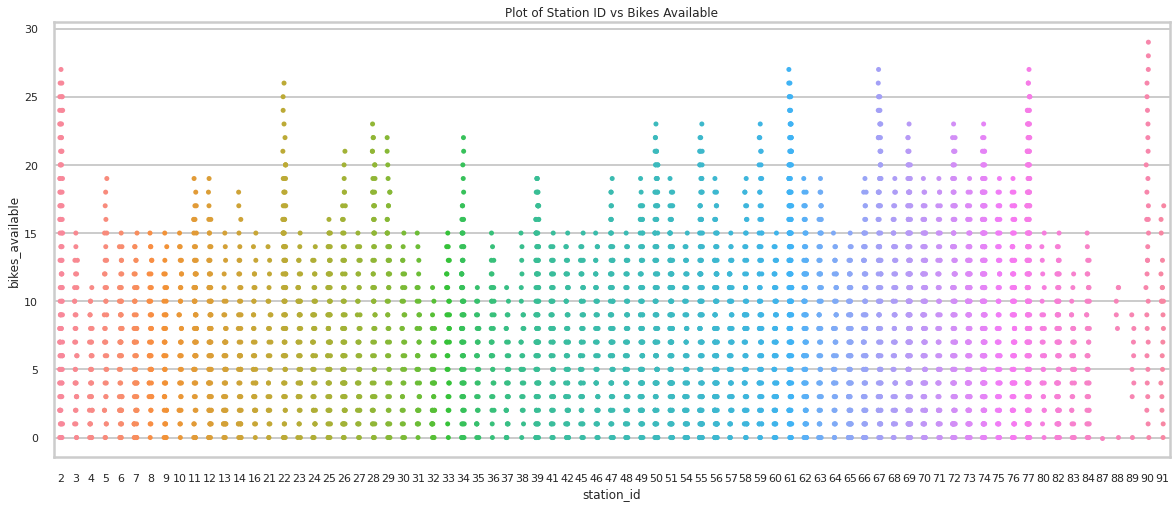

In [28]:

plt.figure(figsize=(20,8))
sns.stripplot(x="station_id", y="bikes_available", data=trip_status,jitter=True,dodge=False).set_title("Plot of Station ID vs Bikes Available")
pass

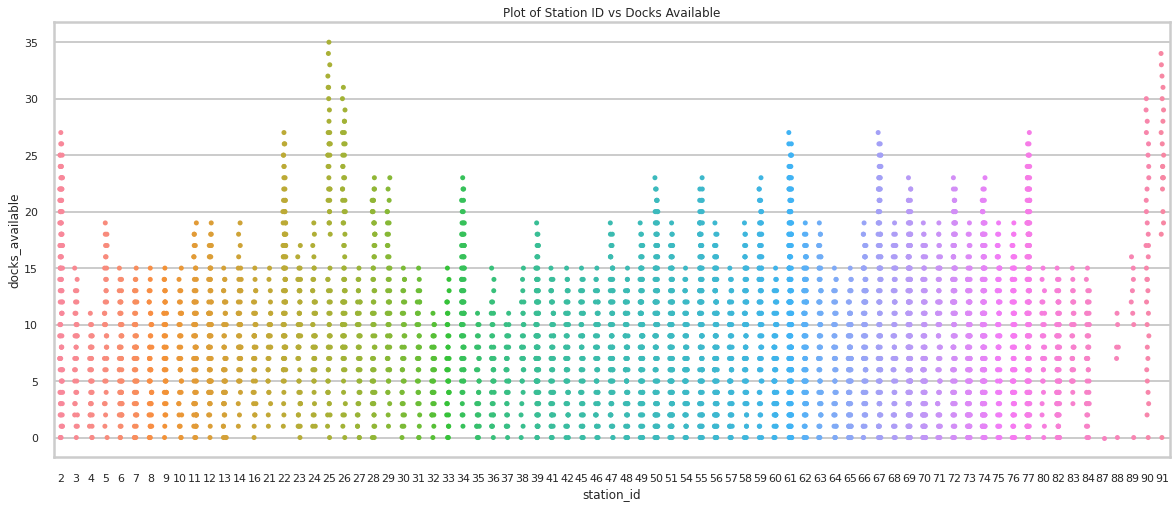

In [29]:
plt.figure(figsize=(20,8))
sns.stripplot(x="station_id", y="docks_available", data=trip_status,jitter=True,dodge=False).set_title("Plot of Station ID vs Docks Available")
pass

In [43]:
%%bigquery bike_status
SELECT DISTINCT bike_number,duration_sec from `bigquery-public-data.san_francisco.bikeshare_trips` LIMIT 50000000

In [44]:
df=bike_status.sort_values(['duration_sec'], ascending=[False]).head(50)
df.head()

,bike_number,duration_sec
16893,535,17270400
464722,466,2137000
392291,680,1852590
336225,262,1133540
336017,247,722236


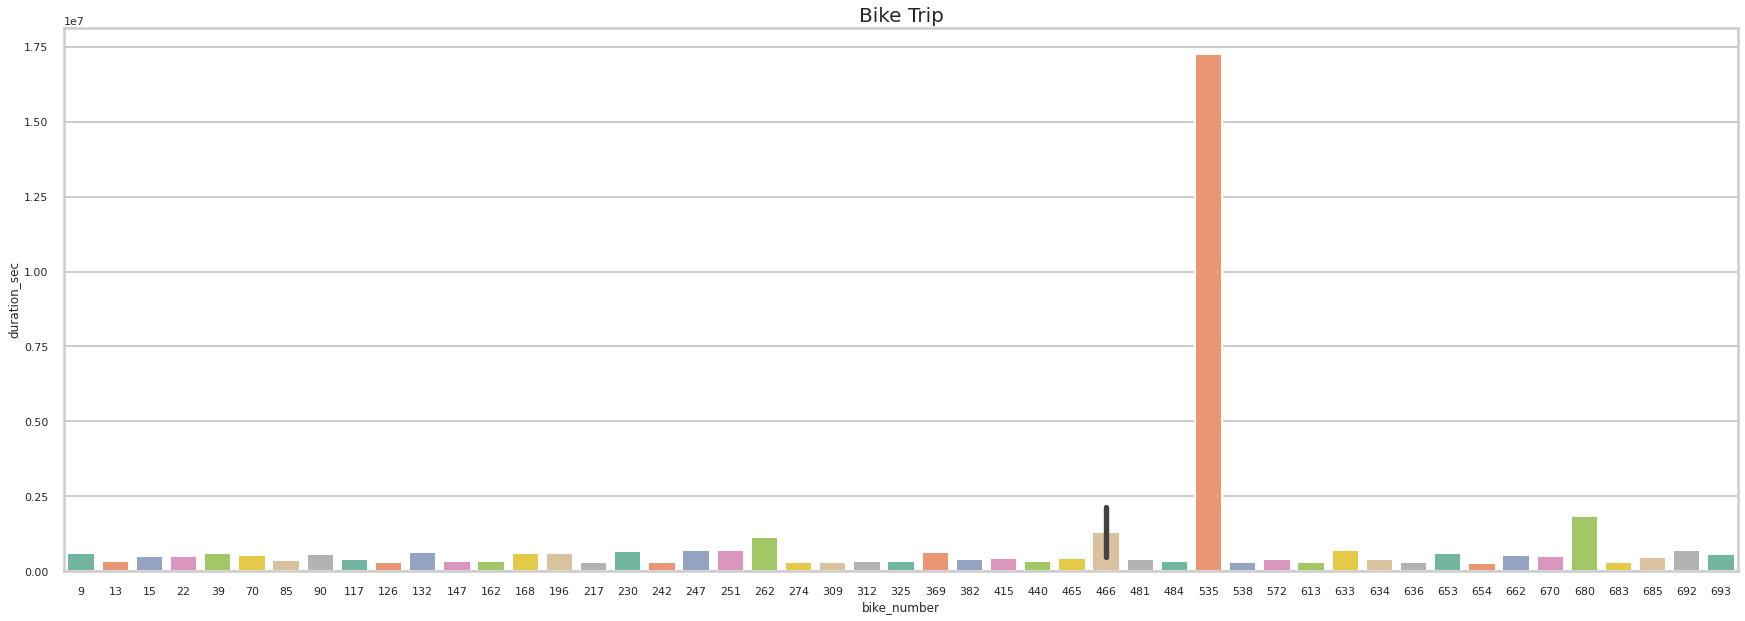

In [45]:
plt.figure(figsize=(30,10)) 
sns.set_context('poster',font_scale=0.5)
sns.set_style('whitegrid')
plt.title('Bike Trip',fontsize =20)
sns.barplot(x="bike_number", y="duration_sec", data=df, palette=sns.color_palette("Set2"))
pass

- The Data Science team at Ford GoBike has been analyzing the numbers from San Francisco bike
share use. During our work, we discovered an opportunity for increased revenue. Currently,
our packages and offerings do not adequately address our customers’ use models. Based on our
assessment, we believe that visitors to SF are likely frustrated by GoBike’s per-trip time limits.
On the reverse side, the data indicates that SF locals and commuters are given a per-trip time
allocation well above their desired amount. This report presents an overview of the our markets
and customers’ use models, analyzes the fit of our current packages, and finally offers suggestions
to management to better match our customers’ desired bikeshare usage.